# Desafio LATAM Data Science 3

## 0 Modulos

In [ ]:
# 1 Carga de modulos
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 1 Carga y exploración de datos

In [48]:
df = pd.read_csv('train.csv', index_col =0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 362 entries, 0 to 461
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   surface_area                   362 non-null    float64
 1   agricultural_land              358 non-null    float64
 2   forest_area                    357 non-null    float64
 3   armed_forces_total             318 non-null    float64
 4   urban_pop_major_cities         360 non-null    float64
 5   urban_pop_minor_cities         360 non-null    float64
 6   national_income                362 non-null    object 
 7   inflation_annual               146 non-null    float64
 8   inflation_monthly              156 non-null    float64
 9   inflation_weekly               20 non-null     float64
 10  mobile_subscriptions           362 non-null    object 
 11  internet_users                 362 non-null    object 
 12  secure_internet_servers_total  352 non-null    float64


In [49]:
# Contamos los datos nulos por columna
df.isnull().sum()[lambda x: x>0]

agricultural_land                  4
forest_area                        5
armed_forces_total                44
urban_pop_major_cities             2
urban_pop_minor_cities             2
inflation_annual                 216
inflation_monthly                206
inflation_weekly                 342
secure_internet_servers_total     10
dtype: int64

Existe variables con demasiados valores falatantes (e.g `inflation_weekly`) y otras con menos `forest_area`. Extraeremos las primeras y aplicaremos imputación a las segundas.

In [50]:
# Extraigo los caso donde hay muchas datos faltantes
df = df.drop(['inflation_annual','inflation_monthly', 'inflation_weekly'], axis = 1)

In [51]:
# Imputacion de datos faltantes por media de cada columna
imputer = SimpleImputer(strategy='mean')

num_cols = df.select_dtypes(include='number').columns
df[num_cols] = imputer.fit_transform(df[num_cols])
type(df)

pandas.core.frame.DataFrame

In [52]:
# Verifcamos si quedan obs perdidas en total
df.isnull().sum().sum()

0

## 2 Descripción numerica y grafica de los datos

In [53]:
df.describe()

,surface_area,agricultural_land,forest_area,armed_forces_total,urban_pop_major_cities,urban_pop_minor_cities,secure_internet_servers_total,life_expectancy
count,3.620000e+02,3.620000e+02,3.620000e+02,3.620000e+02,362.000000,362.000000,3.620000e+02,362.000000
mean,4.021884e+06,1.594881e+08,1.204151e+08,9.849864e+05,27.659456,29.175242,2.949654e+08,71.059691
std,1.234491e+07,4.936564e+08,3.770239e+08,2.806256e+06,20.455984,21.147669,7.133108e+08,8.332818
min,3.030000e+01,3.000000e+02,0.000000e+00,5.000000e+01,0.091444,0.074575,4.002500e+04,48.850634
25%,2.783000e+04,1.101326e+06,5.083646e+05,1.585000e+04,10.637942,11.033595,3.522556e+06,65.469854
50%,2.037745e+05,5.506865e+06,4.012868e+06,8.659000e+04,24.545311,26.969871,2.911352e+07,73.238024
75%,1.081610e+06,4.286507e+07,2.347027e+07,9.849864e+05,38.463620,43.299790,2.508172e+08,77.125610
max,1.343253e+08,5.067600e+09,4.132117e+09,2.720662e+07,92.409069,89.142904,8.207343e+09,83.480488


In [54]:
# Descripción por grupo
df.groupby('improved_sanitation')['life_expectancy'].describe()

,count,mean,std,min,25%,50%,75%,max
improved_sanitation,,,,,,,,
high access,47.0,73.247753,3.075589,65.427780,71.942106,73.839585,74.464634,80.128878
low access,55.0,61.828680,4.835226,49.331463,58.317622,62.033390,66.069134,69.102927
medium access,54.0,67.649673,6.740083,48.850634,64.672562,69.060368,72.091201,77.419220
no info,18.0,75.682654,8.843511,54.690244,73.552823,79.670305,81.141463,83.480488
very high access,155.0,77.020089,3.858466,68.104000,74.170524,76.836195,80.642291,83.331951
very low access,33.0,58.390987,4.371564,49.105293,57.095000,59.121976,61.666390,64.291829


# 3 Correlación y multicolinearidad

In [55]:
c = df.select_dtypes(include='number').corr()
high_pairs = c.abs().stack()[lambda s: (s>0.85) & (s<1)]
high_pairs.index.tolist()


[('surface_area', 'agricultural_land'),
 ('surface_area', 'forest_area'),
 ('surface_area', 'armed_forces_total'),
 ('agricultural_land', 'surface_area'),
 ('agricultural_land', 'forest_area'),
 ('agricultural_land', 'armed_forces_total'),
 ('forest_area', 'surface_area'),
 ('forest_area', 'agricultural_land'),
 ('forest_area', 'armed_forces_total'),
 ('armed_forces_total', 'surface_area'),
 ('armed_forces_total', 'agricultural_land'),
 ('armed_forces_total', 'forest_area')]

<AxesSubplot:>

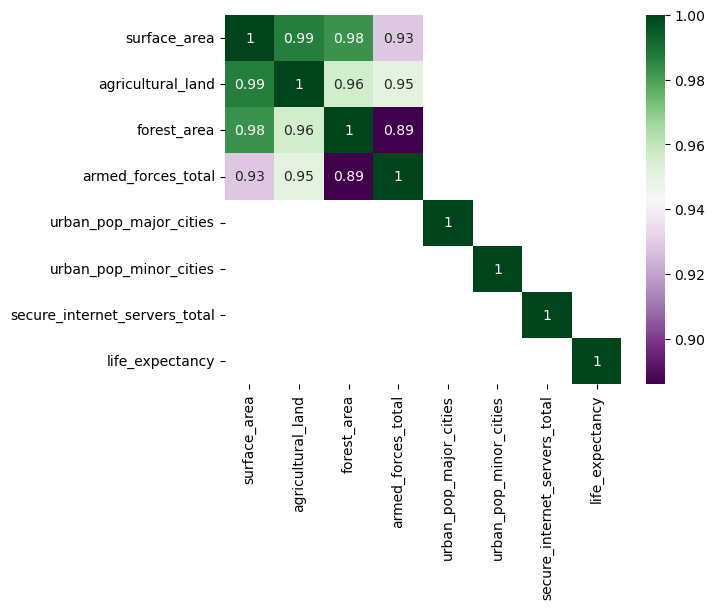

In [56]:
# grafico de calor
sns.heatmap(c_high, cmap='PRGn', annot=True)

In [57]:
# Extrare el coeficiente VIF de las variablesnumericas
X_vif = df.select_dtypes(include=[np.number]).drop(columns=['life_expectancy'])

# Calcular VIF
vif_df = pd.DataFrame()
vif_df['feature'] = X_vif.columns
vif_df['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# MOstrar variables con alta VIF
print(vif_df.sort_values(by='VIF', ascending= True))

                         feature         VIF
6  secure_internet_servers_total    1.280135
4         urban_pop_major_cities    1.502961
5         urban_pop_minor_cities    1.507170
3             armed_forces_total   12.335359
2                    forest_area   42.975558
1              agricultural_land   69.523616
0                   surface_area  136.259330


In [58]:
## Variable a retirar
out = ['surface_area', 'armed_forces_total', 'forest_area', 'agricultural_land']
df = df.drop(columns = out).reset_index(drop=True)


# 4 Data Visualization


<AxesSubplot:title={'center':'life_expectancy'}, xlabel='improved_sanitation'>

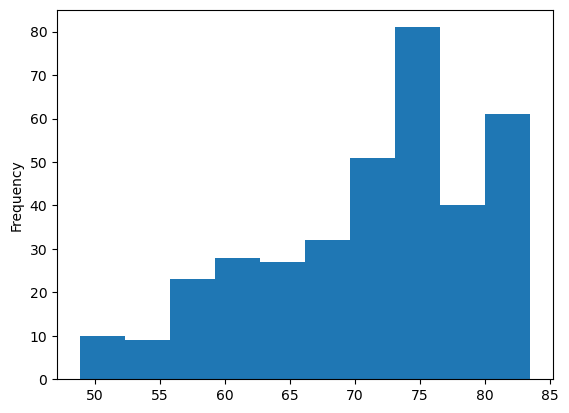

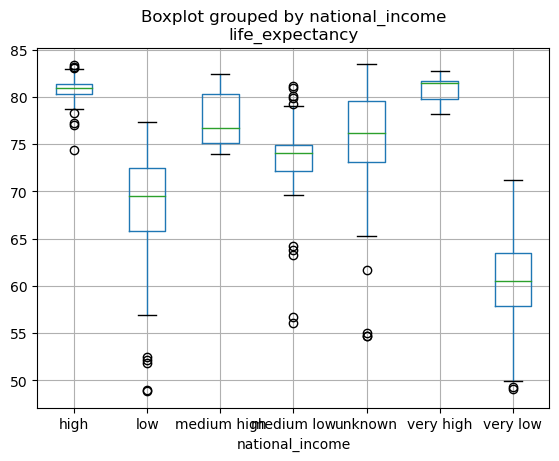

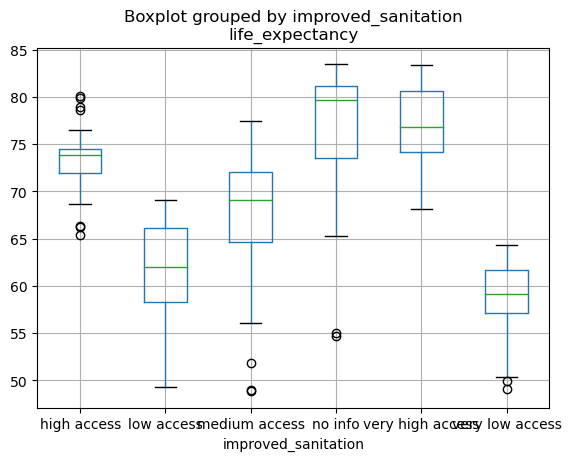

In [59]:
# Histograma de pesranza de vida 
df['life_expectancy'].plot.hist()
df.boxplot(column='life_expectancy', by ='national_income')
df.boxplot(column = 'life_expectancy', by = 'improved_sanitation')


# 5 Verificación de los balances

In [60]:
print(df['internet_users'].value_counts())
print(df['women_parliament_seats_rate'].value_counts())

internet_users
41 per 100 people      8
60 per 100 people      7
46 per 100 people      7
unknown                6
66 per 100 people      5
                      ..
64 per 1000 people     1
154 per 1000 people    1
37 per 1000 people     1
30 per 1000 people     1
374 per 1000 people    1
Name: count, Length: 198, dtype: int64
women_parliament_seats_rate
[0%-25%)     249
[25%-50%)     82
unknown       30
[50%-75%)      1
Name: count, dtype: int64


In [61]:
# Extraemos cosaso unicos
df = df [df['women_parliament_seats_rate'] != '[50%-75%)'].reset_index(drop=True)
df['women_parliament_seats_rate'].value_counts()

women_parliament_seats_rate
[0%-25%)     249
[25%-50%)     82
unknown       30
Name: count, dtype: int64

In [62]:
df = df.drop(['internet_users'], axis=1)


In [63]:
#  Balance para la columna 'national_income'
col = 'national_income'
max_size = df[col].value_counts().max()

df_over = (
    df.groupby(col)
    .apply(lambda x:x.sample(n=max_size, replace= True, random_state=52))
    .reset_index(drop=True)
)


C:\Users\Acer\AppData\Local\Temp\ipykernel_23004\2711290879.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(col)


In [64]:
df_over['national_income'].value_counts()

national_income
high           81
low            81
medium high    81
medium low     81
unknown        81
very high      81
very low       81
Name: count, dtype: int64

# 5 Encoding

In [65]:
no_num = ['national_income', 'mobile_subscriptions', 'improved_sanitation', 'women_parliament_seats_rate']
# Cargo codificador
encoder = OrdinalEncoder()

# Codificar las columnas nonnumericas
df_over[no_num] = encoder.fit_transform(df_over[no_num])

In [66]:
# verificamos
df_over.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   urban_pop_major_cities         567 non-null    float64
 1   urban_pop_minor_cities         567 non-null    float64
 2   national_income                567 non-null    float64
 3   mobile_subscriptions           567 non-null    float64
 4   secure_internet_servers_total  567 non-null    float64
 5   improved_sanitation            567 non-null    float64
 6   women_parliament_seats_rate    567 non-null    float64
 7   life_expectancy                567 non-null    float64
dtypes: float64(8)
memory usage: 35.6 KB


In [67]:
Y= df_over['life_expectancy']
X = df_over.drop('life_expectancy', axis = 1)

## División de los datos de train y test

In [68]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

random_forest = RandomForestRegressor(random_state=53)

# Hiperparametros para explorar
param_grid = {
    'n_estimators':[10,50,100],
    'max_depth': [5,10,20],
    'min_samples_split': [2,5,10],
    'max_leaf_nodes': [5,10,50]
}

# Busqueda grid
grid = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=1)
grid.fit(X_train, Y_train)

mejor_modelo = grid.best_estimator_

# predicciones
Y_pred = mejor_modelo.predict(X_test)
test_mae = mean_absolute_error(Y_test, Y_pred)

# MAE en el data set
print(f"Mejores parametros:{grid.best_params_}")
print(f"MAE promedio {-grid.best_score_:.2f}")
print(f"MAE en test:{test_mae:.2f}")



Mejores parametros:{'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_split': 2, 'n_estimators': 100}
MAE promedio 1.61
MAE en test:1.51


In [69]:
modelo_select = RandomForestRegressor(max_depth=5, max_leaf_nodes=10, min_samples_split=2, n_estimators=100, random_state=53)
modelo_select.fit(X_train, Y_train)

RandomForestRegressor(max_depth=5, max_leaf_nodes=10, random_state=53)

## Predicciones

In [70]:
test = pd.read_csv('test.csv', index_col=0)
# dejamos las columnas empleadas efectvamente
cols = list(df_over.drop('life_expectancy', axis=1).columns)
test=test[cols]
print(test.shape)

(100, 7)


In [71]:
test.isnull().sum()

urban_pop_major_cities           2
urban_pop_minor_cities           2
national_income                  0
mobile_subscriptions             0
secure_internet_servers_total    9
improved_sanitation              0
women_parliament_seats_rate      0
dtype: int64

### Imputación de variables numericas

In [72]:
test = test.fillna(test.mean(numeric_only=True))
test.isnull().sum()

urban_pop_major_cities           0
urban_pop_minor_cities           0
national_income                  0
mobile_subscriptions             0
secure_internet_servers_total    0
improved_sanitation              0
women_parliament_seats_rate      0
dtype: int64

In [73]:
# Codificación de variables cuali
no_num=['national_income', 'mobile_subscriptions', 'improved_sanitation', 'women_parliament_seats_rate']

encoder = OrdinalEncoder()
test[no_num]=  encoder.fit_transform(test[no_num])


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 9 to 455
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   urban_pop_major_cities         100 non-null    float64
 1   urban_pop_minor_cities         100 non-null    float64
 2   national_income                100 non-null    float64
 3   mobile_subscriptions           100 non-null    float64
 4   secure_internet_servers_total  100 non-null    float64
 5   improved_sanitation            100 non-null    float64
 6   women_parliament_seats_rate    100 non-null    float64
dtypes: float64(7)
memory usage: 6.2 KB


In [78]:
y_pred = modelo_select.predict(test)
print(y_pred)

[68.53470789 71.18199044 76.33121722 67.94904449 75.14797974 62.26819108
 74.41221762 71.7476474  73.4295987  73.39614182 73.89448106 80.58565528
 61.4054533  59.98467087 80.58565528 76.68562509 77.03216466 72.61681813
 76.76291826 62.61557737 62.61557737 71.82595618 73.5798421  77.26904501
 74.17060827 72.74602045 59.63982572 80.58565528 80.58565528 79.45989401
 73.62999877 72.50023889 62.62136865 67.73859528 80.58565528 80.44368651
 75.3958852  80.58565528 74.65662411 80.58565528 74.27022584 66.35242308
 68.89848502 58.1301728  59.63982572 77.14226081 62.60661984 64.42233095
 59.61274598 75.80089575 74.32511656 73.96823749 72.89817558 80.58565528
 59.52584634 75.98991146 78.96245978 62.47840314 71.14290614 66.53612662
 71.38782174 68.30957823 59.46087364 68.23708484 70.95875314 56.09390765
 71.95472923 70.28018016 73.88932336 72.76930168 62.61557737 68.07067634
 62.52073886 73.71241105 58.9118718  62.47840314 80.58565528 72.7583001
 77.03216466 72.65865926 77.54890255 72.84522696 74.

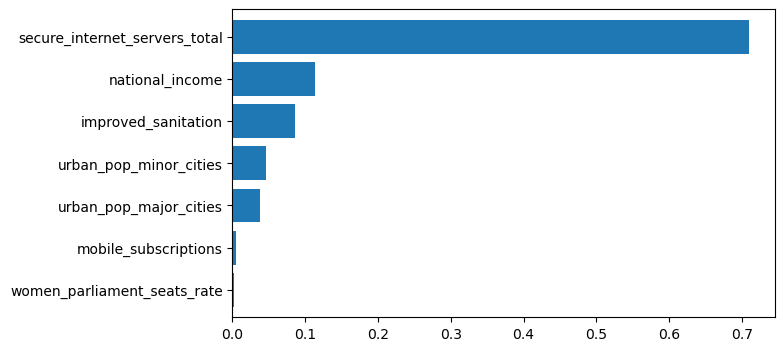

In [81]:

# Extract feature importance determined by RF model
feature_imp = pd.Series(modelo_select.feature_importances_, index=X.columns)
feature_imp.sort_values(ascending=True, inplace=True)

# Creating a bar plot
feature_imp.plot(kind='barh', width=0.8, figsize=(7,4));

In [82]:
d = {'id': test.index, 'life_expectancy': y_pred}
submission_df = pd.DataFrame(data=d)
submission_df.to_csv('submission.csv', index=False)